# Test of new multimodal agent

In [2]:
### data processing imports
import numpy as np
import os
import sys
sys.path.insert(1,'../')

import glob
import json
import datetime

import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.spatial import ConvexHull, Delaunay
from scipy.stats import iqr
from AFL.automation.APIServer.Client import Client
import xarray as xr
import seaborn as sns
from os.path import basename
import pathlib

base_path = pathlib.Path('./')
### Imports for Similarity Metrics


from scipy.spatial.distance import pdist


from tiled.client import from_uri
from tiled.client.cache import Cache
from tiled.queries import Eq, In
from httpx import Timeout

import gpflow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


from AFL.automation import prepare
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions
# from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction,GaussianProcess,HscedGaussianProcess,UCB_AcquisitionFunction

from AFL.automation.APIServer.Client import Client

2023-05-29 23:23:05.144736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 23:23:05.302802: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
%load_ext autoreload
%autoreload 2

# Load dataset

In [4]:
ds_AL = xr.load_dataset('/home/drs18/AFL-Spectroscopy-dev/230529_AL_manifest-P188-PS80_4D_AffProp_turbidityAdded.nc')

In [53]:
ds_AL

<xarray.Dataset>
Dimensions:                      (sample: 88, q: 500, wavelength: 2048)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
Dimensions without coordinates: sample
Data variables: (12/24)
    fname                        (sample) object 'AL_P188-PS80_4D_AffProp_03c...
    SAS                          (sample, q) float64 81.26 79.44 ... 49.54 49.54
    label                        (sample) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    validated                    (sample) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    SAS_transmission             (sample) float64 0.8104 0.8119 ... 0.7945
    sample_uuid                  (sample) object 'fcbedf59-358d-4d78-8465-a2b...
    ...                           ...
    spec_error                   (sample, wavelength) float64 0.0 2.0 ... 2.0
    PS80                         (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mfrac_PS80                   (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mass_PS80                    (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sample_uuid_short            (sample) object '03c94ff0' ... 'fefe63be'
    turbidity                    (sample) float64 0.9765 0.975 ... 0.9862 0.9737
Attributes: (12/32)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    P188_range:                        [ 1 25]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         12
    benzyl_alcohol_solute_npts:        15
    ...                                ...
    SAS_savgol_pedestal:               1e-12
    SAS_savgol_npts:                   250
    SAS_savgol_window_length:          31
    SAS_savgol_polyorder:              2
    SAS_savgol_logx:                   1
    SAS_savgol_logy:                   1

# Create Grid

In [6]:
deck =  prepare.Deck()

tipracks=[(3,'opentrons_96_tiprack_300ul'),(5,'opentrons_96_tiprack_300ul')]
deck.add_pipette('p300_single_gen2','left',tipracks=tipracks)

tipracks=[(6,'opentrons_96_tiprack_1000ul'),(9,'opentrons_96_tiprack_1000ul')]
deck.add_pipette('p1000_single_gen2','right',tipracks=tipracks)

deck.add_container('nist_6_20ml_vials',1)
deck.add_container('nist_2_100ml_poly_bottle',2)

deck.add_container('nest_96_wellplate_1600ul',4)
deck.add_container('nest_96_wellplate_1600ul',8)

catch_loc = '10A1'
deck.add_catch ('nist_pneumatic_loader',10)

In [7]:
prepare.db.read()
prepare.db

deck.reset_stocks()

stock_D2O = prepare.Solution('stock_buffer',['D2O'])
stock_D2O.volume = 20*units("ml")
deck.add_stock(stock_D2O,'2A1')

stock_PS = prepare.Solution('stock_PS80',['D2O','PS80'])
stock_PS.volume = 20*units("ml")
stock_PS.concentration = {'PS80':100.87*units('mg/ml')}
deck.add_stock(stock_PS,'1A3')

stock_Px = prepare.Solution('stock_Px',['D2O','P188'])
stock_Px.volume = 20*units("ml")
stock_Px.concentration = {'P188':102.83*units('mg/ml')}
deck.add_stock(stock_Px,'1B3')

stock_Bz = prepare.Solution('stock_Bz',['D2O','benzyl_alcohol_solute'])
stock_Bz.volume = 20*units("ml")
stock_Bz.concentration = {'benzyl_alcohol_solute':30.58*units('mg/ml')}
deck.add_stock(stock_Bz,'1A2')

stock_Ph = prepare.Solution('stock_Ph',['D2O','phenol_solute'])
stock_Ph.volume = 20*units("ml")
stock_Ph.concentration = {'phenol_solute':32.61*units('mg/ml')}
deck.add_stock(stock_Ph,'1A1')

components = ['PS80','P188','benzyl_alcohol_solute','phenol_solute','D2O']
AL_components = ['PS80','P188','benzyl_alcohol_solute','phenol_solute']
AL_components_grid = [k+'_grid' for k in AL_components]

In [9]:
MB = deck.make_mass_balance()
MB.process_components()
samples = MB.sample_composition_space(grid_density=5,pipette_min=5*units('ul'),composition_data='conc')
samples1 = MB.constrain_samples_conc(
    {
        'PS80':{'value':30*units('mg/ml'), 'compare':'lt'},
        'P188':{'value':30*units('mg/ml'), 'compare':'lt'},
        'benzyl_alcohol_solute':{'value':20*units('mg/ml'), 'compare':'lt'},
        'phenol_solute':{'value':20*units('mg/ml'), 'compare':'lt'},
    },
    rtol=0.05)

MB.stock_samples.attrs['components'] = AL_components
MB.stock_samples.attrs['PS80_range'] = [1,10]
MB.stock_samples.attrs['P188_range'] = [1,10]
MB.stock_samples.attrs['benzyl_alcohol_solute_range'] = [0,5]
MB.stock_samples.attrs['phenol_solute_range'] = [0,5]
MB.stock_samples.attrs['P188_npts'] = 6
MB.stock_samples.attrs['PS80_npts'] = 6
MB.stock_samples.attrs['benzyl_alcohol_solute_npts'] = 6
MB.stock_samples.attrs['phenol_solute_npts'] = 6
MB.stock_samples.attrs['PS80_units'] = 'mg/ml'
MB.stock_samples.attrs['benzyl_alcohol_solute_units'] = 'mg/ml'
MB.stock_samples.attrs['phenol_solute_units'] = 'mg/ml'

  0%|          | 0/32768 [00:00<?, ?it/s]

In [10]:
MB.calculate_bounds(components=AL_components,exclude_comps_below=0.0001,composition_data='samples_conc',ternary=False)
MB.make_grid_mask(pts_per_row=None,ternary=False)
MB.stock_samples

--> Making grid for components ['PS80', 'P188', 'benzyl_alcohol_solute', 'phenol_solute'] at None pts_per_row
{'PS80': {'min': 1, 'max': 10, 'steps': 6}, 'P188': {'min': 1, 'max': 10, 'steps': 6}, 'benzyl_alcohol_solute': {'min': 0, 'max': 5, 'steps': 6}, 'phenol_solute': {'min': 0, 'max': 5, 'steps': 6}}


  0%|          | 0/1296 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                     (sample: 11784, component: 5, stock: 5,
                                 sample_valid: 11784, coord: 4, grid: 1296)
Coordinates:
  * component                   (component) <U21 'D2O' ... 'phenol_solute'
  * stock                       (stock) <U12 'stock_buffer' ... 'stock_Ph'
  * grid                        (grid) MultiIndex
  - PS80_grid                   (grid) float64 1.0 1.0 1.0 ... 10.0 10.0 10.0
  - P188_grid                   (grid) float64 1.0 1.0 1.0 ... 10.0 10.0 10.0
  - benzyl_alcohol_solute_grid  (grid) float64 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0
  - phenol_solute_grid          (grid) float64 0.0 1.0 2.0 3.0 ... 3.0 4.0 5.0
Dimensions without coordinates: sample, sample_valid, coord
Data variables: (12/14)
    samples_frac                (sample, component) float64 0.9541 ... 0.005606
    samples_mass                (sample, component) float64 27.75 ... 652.2
    samples_conc                (sample, component) float64 1.11e+03 ... 6.522
    samples_volume              (sample) float64 0.025 0.09453 ... 95.0 100.0
    stock_fractions             (sample, stock) float64 0.00025 0.00025 ... 1.0
    D2O                         (sample) float64 1.11e+03 1.11e+03 ... 1.11e+03
    ...                          ...
    benzyl_alcohol_solute       (sample) float64 6.116 12.86 ... 6.438 6.116
    phenol_solute               (sample) float64 6.522 13.72 ... 5.149 6.522
    constraint_mask             (sample) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    xy                          (sample_valid, coord) float64 20.17 ... 6.522
    samples_valid               (sample_valid, component) float64 1.11e+03 .....
    grid_mask                   (grid) bool False False False ... True True True
Attributes: (12/19)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    PS80_range:                        [1, 10]
    P188_range:                        [1, 10]
    benzyl_alcohol_solute_range:       [0, 5]
    phenol_solute_range:               [0, 5]
    P188_npts:                         6
    ...                                ...
    delaunay:                          <scipy.spatial._qhull.Delaunay object ...
    components_grid:                   ['PS80_grid', 'P188_grid', 'benzyl_alc...
    PS80_grid_range:                   [1, 10]
    P188_grid_range:                   [1, 10]
    benzyl_alcohol_solute_grid_range:  [0, 5]
    phenol_solute_grid_range:          [0, 5]

In [11]:
stock_samples = MB.stock_samples.reset_index('grid').reset_coords().set_index(grid='grid_mask').sel(grid=True).reset_index('grid').reset_coords().rename({'grid_':'mask'})
stock_samples

<xarray.Dataset>
Dimensions:                     (sample: 11784, component: 5, stock: 5,
                                 sample_valid: 11784, coord: 4, grid: 900)
Coordinates:
  * component                   (component) <U21 'D2O' ... 'phenol_solute'
  * stock                       (stock) <U12 'stock_buffer' ... 'stock_Ph'
Dimensions without coordinates: sample, sample_valid, coord, grid
Data variables: (12/18)
    samples_frac                (sample, component) float64 0.9541 ... 0.005606
    samples_mass                (sample, component) float64 27.75 ... 652.2
    samples_conc                (sample, component) float64 1.11e+03 ... 6.522
    samples_volume              (sample) float64 0.025 0.09453 ... 95.0 100.0
    stock_fractions             (sample, stock) float64 0.00025 0.00025 ... 1.0
    D2O                         (sample) float64 1.11e+03 1.11e+03 ... 1.11e+03
    ...                          ...
    samples_valid               (sample_valid, component) float64 1.11e+03 .....
    PS80_grid                   (grid) float64 1.0 1.0 1.0 ... 10.0 10.0 10.0
    P188_grid                   (grid) float64 1.0 1.0 1.0 ... 10.0 10.0 10.0
    benzyl_alcohol_solute_grid  (grid) float64 1.0 1.0 1.0 1.0 ... 5.0 5.0 5.0
    phenol_solute_grid          (grid) float64 1.0 2.0 3.0 4.0 ... 3.0 4.0 5.0
    mask                        (grid) bool True True True ... True True True
Attributes: (12/19)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    PS80_range:                        [1, 10]
    P188_range:                        [1, 10]
    benzyl_alcohol_solute_range:       [0, 5]
    phenol_solute_range:               [0, 5]
    P188_npts:                         6
    ...                                ...
    delaunay:                          <scipy.spatial._qhull.Delaunay object ...
    components_grid:                   ['PS80_grid', 'P188_grid', 'benzyl_alc...
    PS80_grid_range:                   [1, 10]
    P188_grid_range:                   [1, 10]
    benzyl_alcohol_solute_grid_range:  [0, 5]
    phenol_solute_grid_range:          [0, 5]

In [12]:
grid_mask = stock_samples[['mask']+AL_components_grid]
grid_mask.attrs.update(stock_samples.attrs)
# grid_mask.values.shape

AttributeError: 'function' object has no attribute 'shape'

In [26]:
# ds_AL = ds_AL.drop_dims('grid')
# ds_AL.update(grid_mask)
# ds_AL
grid_mask.mask.sum().values

array(23958)

# Testing the GPR

In [12]:
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=1.0) + gpflow.kernels.White(1e-1)
regressor = HscedGaussianProcess.GPR(
    kernel=kernel,
    dataset=ds_AL,
    heteroscedastic=False
)


regressor.optimize(150,progress_bar=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 51.96it/s]


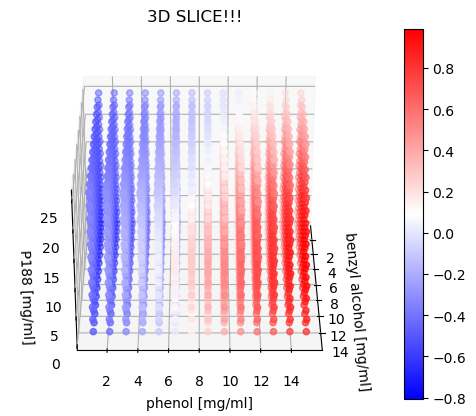

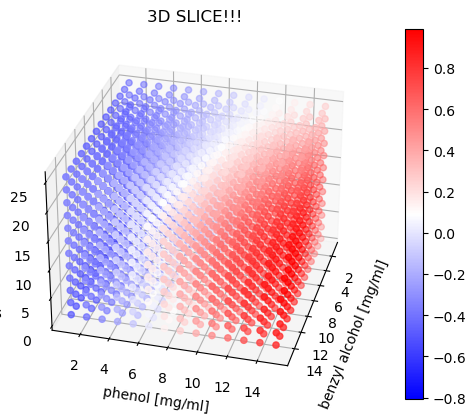

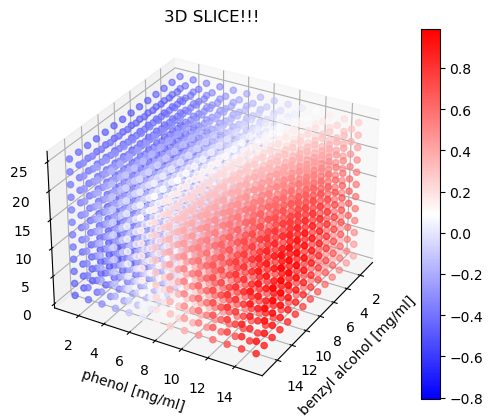

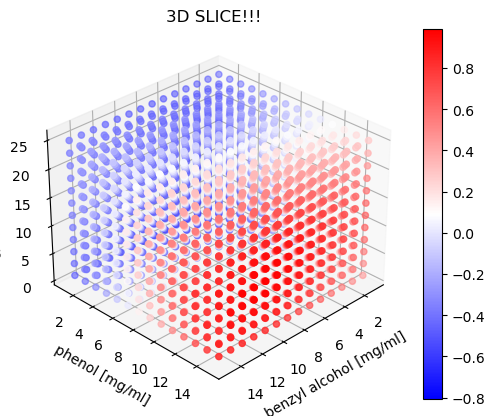

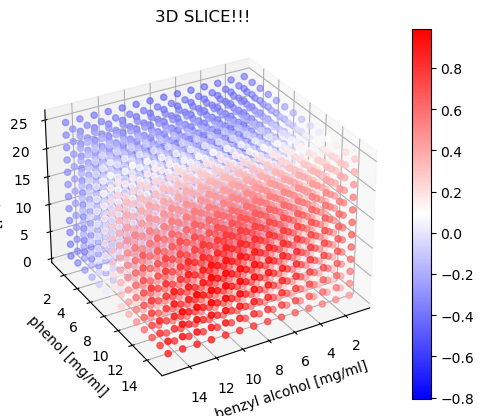

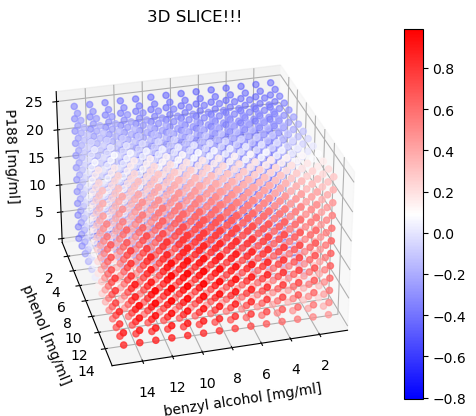

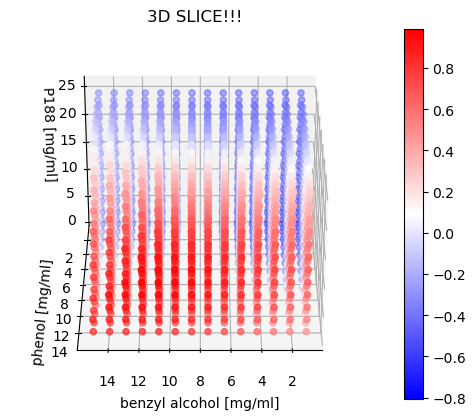

In [13]:
# %matplotlib tk
result = regressor.predict(ds_AL.attrs['components_grid'])
# X = regressor.transform_domain(components=ds_AL.attrs['components_grid']).values
# print(ds_AL.attrs['components_grid'])
# for col in X.T:
#     print(min(col),max(col))
# regressor.construct_data(heteroscedastic=False)
ds_AL['GP_mean'] = ('grid',result['mean'].squeeze())
ds_AL['GP_var'] = ('grid',result['var'].squeeze())

# ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GP_mean')
# ds_AL.afl.comp.plot_surface(ds_AL.attrs['components_grid'],labels='GP_var')


# mask = np.isclose(ds_AL.PS80_grid,1.0,rtol=0.05)
# len(mask[mask==True])
# mask = mask|np.isclose(ds_AL.P188_grid,10.0,rtol=0.05)
# mask = ds_AL.PS80_grid.copy(data=mask)
# ds_plot = ds_AL.where(mask,drop=True)
# x = ds_plot.benzyl_alcohol_solute_grid
# y = ds_plot.phenol_solute_grid
# z = ds_plot.P188_grid
# c = ds_plot.turbidity

# filter = ds_AL.GP_mean.where(ds_AL.P188_grid.values<11.& ds_AL.P188_grid.values>9.)
# x = ds_AL.benzyl_alcohol_solute_grid.where(ds_AL.P188_grid.values<11.& ds_AL.P188_grid.values>9.)
# y = ds_AL.phenol_solute_grid.where(ds_AL.P188_grid.values<11.& ds_AL.P188_grid.values>9.)
# z = ds_AL.P188_grid.where(ds_AL.P188_grid.values<11.& ds_AL.P188_grid.values>9.)

filter = ds_AL.GP_mean.where(ds_AL.PS80_grid.values<2.)
x = ds_AL.benzyl_alcohol_solute_grid.where(ds_AL.PS80_grid.values<2.)
y = ds_AL.phenol_solute_grid.where(ds_AL.PS80_grid.values<2.)
z = ds_AL.P188_grid.where(ds_AL.PS80_grid.values<2.)

for az in np.linspace(0,90,7):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30,az)
    sp = ax.scatter3D(xs=x,ys=y,zs=z,c=filter,cmap='bwr')
    plt.colorbar(sp)
    ax.set(
        xlabel='benzyl alcohol [mg/ml]',
        ylabel='phenol [mg/ml]',
        zlabel='P188 [mg/ml]',
        title='3D SLICE!!!'
    )
# for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)


## sanity check

In [97]:
# #constructing data
# x,y = regressor.construct_data(heteroscedastic=False)
# y = np.expand_dims(y,axis=1)
# print(x.shape,y.shape)
# model = gpflow.models.GPR(data=(x,y),kernel=kernel)

# #optimization
# import tensorflow as tf
# optimizer = tf.optimizers.Adam(learning_rate=0.001)
# for n in range(1000):
#     optimizer.minimize(model.training_loss,model.trainable_variables)

# #prediction
# model.predict_f(regressor.transform_domain(ds_AL.attrs['components_grid']).values)

(88, 4) (88, 1)


(<tf.Tensor: shape=(23958, 1), dtype=float64, numpy=
 array([[-0.98388844],
        [-0.9297894 ],
        [-0.86264207],
        ...,
        [-0.65464672],
        [-0.57255839],
        [-0.61899223]])>,
 <tf.Tensor: shape=(23958, 1), dtype=float64, numpy=
 array([[0.18279858],
        [0.14333436],
        [0.11137336],
        ...,
        [0.24327083],
        [0.23550747],
        [0.25993296]])>)

# MM AL Server test

In [37]:
agent_client = AgentClient('localhost',5053)
agent_client.login('test')
agent_client.pause(False)
# agent_client.get_unqueued_commmands()

/home/drs18/AFL-agent/AFL/agent/xarray_extensions.py:17: AccessorRegistrationWarning: registration of accessor <class 'AFL.agent.xarray_extensions.AFL_DataArrayTools'> under name 'afl' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class AFL_DataArrayTools:
/home/drs18/AFL-agent/AFL/agent/xarray_extensions.py:25: AccessorRegistrationWarning: registration of accessor <class 'AFL.agent.xarray_extensions.AFL_DatasetTools'> under name 'afl' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class AFL_DatasetTools:


In [44]:
data_tag = "Test"
agent_client.set_config(
    compute_device='/device:GPU:0',
    data_path='/home/drs18/test_data_storage/',
    save_path='/home/drs18/test_data_storage/',
    AL_manifest_file='/home/drs18/AFL-Spectroscopy-dev/230529_AL_manifest-P188-PS80_4D_AffProp_turbidityAdded.nc',
    data_tag=data_tag,
    qlo = 0.01,
    qhi = 0.25,
    subtract_background=False
)


# metric1 = Metric.Similarity('deriv0',  name='deriv0',  params=dict(metric='poly',gamma=0.01,power=0.5))
metric2 = Metric.Similarity('deriv1',name='deriv1',params=dict(metric='poly',gamma=0.1,power=0.5))
# metric3 = Metric.Similarity('deriv2',name='deriv2',params=dict(metric='poly',gamma=0.1,power=0.5))
metric1 = Metric.Similarity('deriv0',  name='deriv0',  params=dict(metric='laplacian',gamma=0.0025))
# metric2 = Metric.Similarity('deriv1',name='deriv1',params=dict(metric='laplacian',gamma=0.1))
metric3 = Metric.Similarity('deriv2',name='deriv2',params=dict(metric='laplacian',gamma=0.0025))

metric4 = Metric.Similarity(['P188','PS80','benzyl_alcohol_solute','phenol_solute'],name='comp',params=dict(metric='laplacian',gamma=0.0025))
metric = Metric.MultiMetric(
    [metric1,metric2,metric3,metric4],
    combine_by='sum',
    combine_by_powers=[0,1,0,0],
    combine_by_coeffs=[1,1,0,0],
    constrain_same=None,
    constrain_different=None,
)
agent_client.set_driver_object(metric=metric)

# labeler=PhaseLabeler.SpectralClustering()
labeler=PhaseLabeler.AffinityPropagation()
agent_client.set_driver_object(labeler=labeler)

# metric = Metric.Dummy()
# agent_client.set_driver_object(metric=metric)
# # model_q = np.geomspace(0.01,0.1,250)
# # labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/keras_models/221203_keras_clf_0p01_0p1_250_bg.tf/',model_q=model_q)
# # labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/keras_models/221201_keras_clf_0p01_0p1_250_bg.tf/',model_q=model_q)
# model_q = np.geomspace(0.0127,0.24,250)
# labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/2211_SINQ_briefcase/221105_keras_clf.tf/',model_q=model_q)
# agent_client.set_driver_object(labeler=labeler)
# AL_kwargs['classifier_qmin'] = model_q.min()
# AL_kwargs['classifier_qmax'] = model_q.max()

from AFL.agent import UCB_AcquisitionFunction

# acq = AcquisitionFunction.IterationCombined(
#     function1=AcquisitionFunction.Variance(),
#     function2=AcquisitionFunction.LowestDensity(bandwidth=2.0),
#     # function2=AcquisitionFunction.Random(),
#     function2_frequency=5
# )

acq = UCB_AcquisitionFunction.pseudoUCB(scaling=1.0,Thompson_sampling=False)

# acq = AcquisitionFunction.LowestDensity(bandwidth=0.025)
# acq = AcquisitionFunction.LowestDensity(bandwidth=0.075)
# acq = AcquisitionFunction.LowestDensity(bandwidth=2.0)
acq.composition_atol = 0.05
agent_client.set_driver_object(acquisition=acq)



/home/drs18/AFL-agent/AFL/agent/xarray_extensions.py:17: AccessorRegistrationWarning: registration of accessor <class 'AFL.agent.xarray_extensions.AFL_DataArrayTools'> under name 'afl' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class AFL_DataArrayTools:
/home/drs18/AFL-agent/AFL/agent/xarray_extensions.py:25: AccessorRegistrationWarning: registration of accessor <class 'AFL.agent.xarray_extensions.AFL_DatasetTools'> under name 'afl' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class AFL_DatasetTools:


<Response [200]>

In [45]:
# mask = np.isclose(ds.P188_grid,10.0,rtol=0.1)
# ds.sel(sample=grid_mask)
#pushing up the mask kills the kernel
# grid_mask


In [46]:
agent_client.set_driver_object(mask=grid_mask)

<Response [200]>

In [47]:
agent_client.get_config('all',interactive=True)

{'ended': '05/29/23 23:38:41-257315 ',
 'exit_state': 'Success!',
 'queued': '05/29/23 23:38:41-256119',
 'return_val': {'AL_manifest_file': '/home/drs18/AFL-Spectroscopy-dev/230529_AL_manifest-P188-PS80_4D_AffProp_turbidityAdded.nc',
  'compute_device': '/device:GPU:0',
  'data_path': '/home/drs18/test_data_storage/',
  'data_tag': 'Test',
  'qhi': 0.25,
  'qlo': 0.01,
  'save_path': '/home/drs18/test_data_storage/',
  'subtract_background': False},
 'run_time_minutes': 0.0,
 'run_time_seconds': 0,
 'started': '05/29/23 23:38:41-257085 '}

# Check Agent Calculations

It is necessary to run the agent client through one cycle before starting the AL

In [48]:
#agent_client.enqueue(task_name='read_data',interactive=True)
#agent_client.enqueue(task_name='label',interactive=False)
#agent_client.enqueue(task_name='extrapolate',interactive=False)
# agent_client.enqueue(task_name='get_next_sample',interactive=True)
agent_client.enqueue(task_name='predict',datatype='nc',interactive=False)

UUID('df36f138-d0e1-4b62-a158-0197e1e68083')

NameError: name 'ag' is not defined

In [62]:
data_tag = "Test"
agent_client.set_config(
    compute_device='/device:GPU:0',
    data_path='/home/drs18/test_data_storage/',
    save_path='/home/drs18/test_data_storage/',
    AL_manifest_file='/home/drs18/AFL-Spectroscopy-dev/230529_AL_manifest-P188-PS80_4D_AffProp_turbidityAdded.nc',
    data_tag=data_tag,
    qlo = 0.01,
    qhi = 0.25,
    subtract_background=False
)


# metric1 = Metric.Similarity('deriv0',  name='deriv0',  params=dict(metric='poly',gamma=0.01,power=0.5))
metric2 = Metric.Similarity('SAS_deriv1',name='deriv1',params=dict(metric='poly',gamma=0.1,power=0.5))
# metric3 = Metric.Similarity('deriv2',name='deriv2',params=dict(metric='poly',gamma=0.1,power=0.5))
metric1 = Metric.Similarity('SAS_deriv0',  name='deriv0',  params=dict(metric='laplacian',gamma=0.0025))
# metric2 = Metric.Similarity('deriv1',name='deriv1',params=dict(metric='laplacian',gamma=0.1))
metric3 = Metric.Similarity('SAS_deriv2',name='deriv2',params=dict(metric='laplacian',gamma=0.0025))

metric4 = Metric.Similarity(['P188','PS80','benzyl_alcohol_solute','phenol_solute'],name='comp',params=dict(metric='laplacian',gamma=0.0025))
metric = Metric.MultiMetric(
    [metric1,metric2,metric3,metric4],
    combine_by='sum',
    combine_by_powers=[0,1,0,0],
    combine_by_coeffs=[1,1,0,0],
    constrain_same=None,
    constrain_different=None,
)
agent_client.set_driver_object(metric=metric)

# labeler=PhaseLabeler.SpectralClustering()
labeler=PhaseLabeler.AffinityPropagation()
agent_client.set_driver_object(labeler=labeler)

# metric = Metric.Dummy()
# agent_client.set_driver_object(metric=metric)
# # model_q = np.geomspace(0.01,0.1,250)
# # labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/keras_models/221203_keras_clf_0p01_0p1_250_bg.tf/',model_q=model_q)
# # labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/keras_models/221201_keras_clf_0p01_0p1_250_bg.tf/',model_q=model_q)
# model_q = np.geomspace(0.0127,0.24,250)
# labeler = PhaseLabeler.KerasClassifier(model_path='/home/afl642/2211_SINQ_briefcase/221105_keras_clf.tf/',model_q=model_q)
# agent_client.set_driver_object(labeler=labeler)
# AL_kwargs['classifier_qmin'] = model_q.min()
# AL_kwargs['classifier_qmax'] = model_q.max()

from AFL.agent import UCB_AcquisitionFunction

# acq = AcquisitionFunction.IterationCombined(
#     function1=AcquisitionFunction.Variance(),
#     function2=AcquisitionFunction.LowestDensity(bandwidth=2.0),
#     # function2=AcquisitionFunction.Random(),
#     function2_frequency=5
# )

acq = UCB_AcquisitionFunction.pseudoUCB(scaling=1.0,Thompson_sampling=False)

# acq = AcquisitionFunction.LowestDensity(bandwidth=0.025)
# acq = AcquisitionFunction.LowestDensity(bandwidth=0.075)
# acq = AcquisitionFunction.LowestDensity(bandwidth=2.0)
acq.composition_atol = 0.05
agent_client.set_driver_object(acquisition=acq)
agent_client.set_driver_object(mask=grid_mask)
agent_client.enqueue(task_name='predict',datatype='nc',interactive=False)

UUID('7c7ee7df-f8e5-4f83-b17f-d08180dd7720')

In [58]:
ds_AL

<xarray.Dataset>
Dimensions:                      (sample: 88, q: 500, wavelength: 2048)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
Dimensions without coordinates: sample
Data variables: (12/24)
    fname                        (sample) object 'AL_P188-PS80_4D_AffProp_03c...
    SAS                          (sample, q) float64 81.26 79.44 ... 49.54 49.54
    label                        (sample) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    validated                    (sample) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    SAS_transmission             (sample) float64 0.8104 0.8119 ... 0.7945
    sample_uuid                  (sample) object 'fcbedf59-358d-4d78-8465-a2b...
    ...                           ...
    spec_error                   (sample, wavelength) float64 0.0 2.0 ... 2.0
    PS80                         (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mfrac_PS80                   (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mass_PS80                    (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sample_uuid_short            (sample) object '03c94ff0' ... 'fefe63be'
    turbidity                    (sample) float64 0.9765 0.975 ... 0.9862 0.9737
Attributes: (12/32)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    P188_range:                        [ 1 25]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         12
    benzyl_alcohol_solute_npts:        15
    ...                                ...
    SAS_savgol_pedestal:               1e-12
    SAS_savgol_npts:                   250
    SAS_savgol_window_length:          31
    SAS_savgol_polyorder:              2
    SAS_savgol_logx:                   1
    SAS_savgol_logy:                   1

In [63]:
ds_calc = agent_client.get_driver_object('dataset')
ds_calc

<xarray.Dataset>
Dimensions:                      (sample: 88, q: 500, wavelength: 2048,
                                  logq: 250, grid: 900, sample_i: 88,
                                  sample_j: 88, phase_num: 9, component: 4)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
  * logq                         (logq) float64 -1.985 -1.975 ... -0.6022
  * component                    (component) <U21 'PS80' ... 'phenol_solute'
Dimensions without coordinates: sample, grid, sample_i, sample_j, phase_num
Data variables: (12/41)
    fname                        (sample) object 'AL_P188-PS80_4D_AffProp_03c...
    SAS                          (sample, q) float64 81.26 79.44 ... 49.54 49.54
    label                        (sample) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    validated                    (sample) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    SAS_transmission             (sample) float64 0.8104 0.8119 ... 0.7945
    sample_uuid                  (sample) object 'fcbedf59-358d-4d78-8465-a2b...
    ...                           ...
    acq_metric                   (grid) float64 -0.04169 -0.08185 ... 0.6381
    gp_classifier_y_var          (grid, phase_num) float64 0.1417 ... 0.0005367
    gp_classifier_y_mean         (grid, phase_num) float64 0.171 ... 0.000537
    gp_regressor_y_mean          (grid) float64 -0.7723 -0.7697 ... 0.2137
    gp_regressor_y_var           (grid) float64 0.1734 0.1352 ... 0.09014
    next_sample                  (component) float64 10.0 10.0 5.0 5.0
Attributes: (12/41)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    P188_range:                        [ 1 25]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         12
    benzyl_alcohol_solute_npts:        15
    ...                                ...
    uuid:                              8bd3ce53-a335-431b-bbfd-c7d4b1564299
    date:                              230529
    time:                              23:57:35
    data_tag:                          Test
    acq_count:                         1
    iteration:                         1

In [ ]:
x = ds_

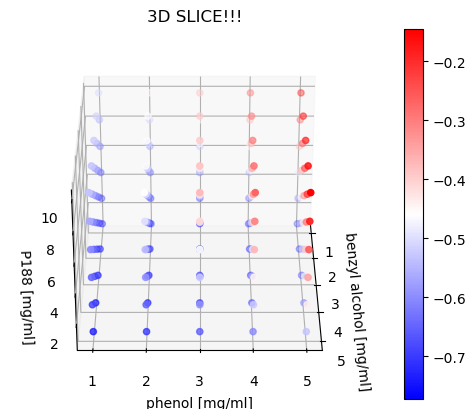

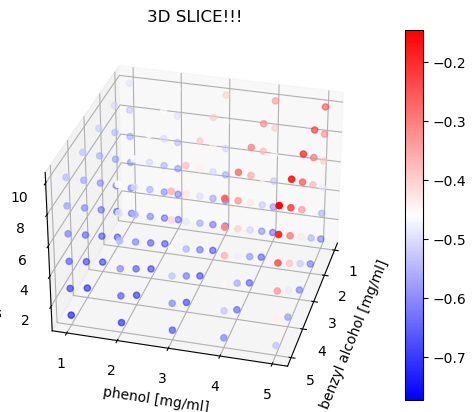

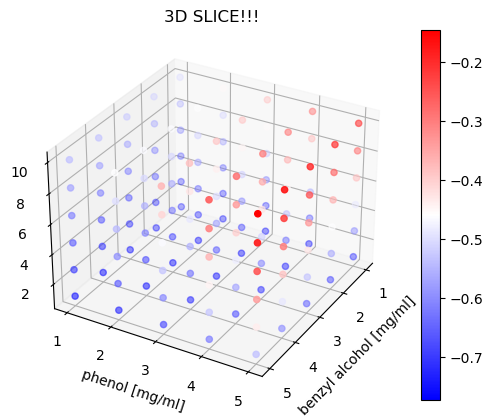

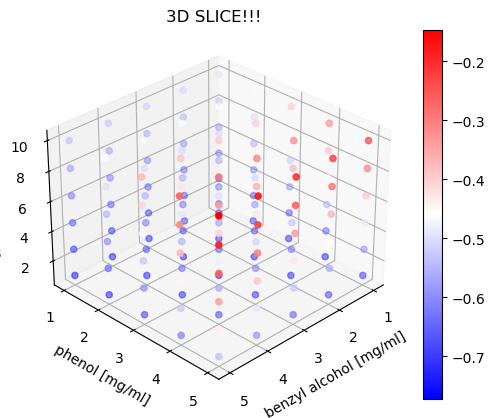

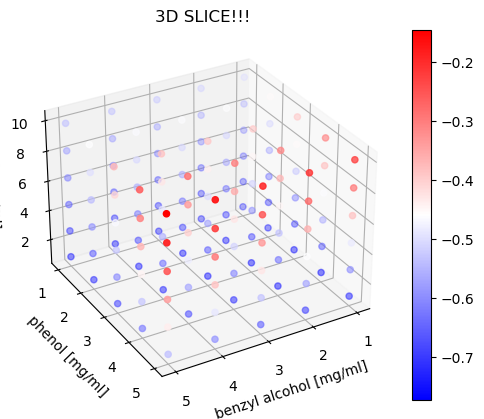

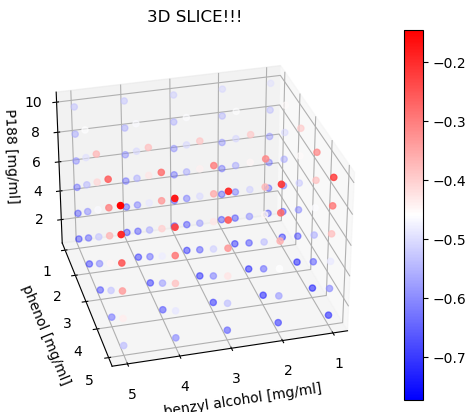

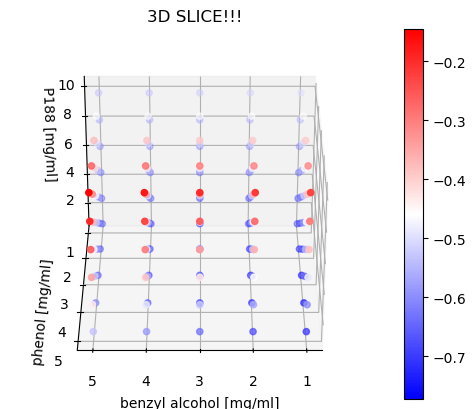

In [65]:
filter = ds_calc.gp_regressor_y_mean.where(ds_calc.PS80_grid.values<2.)
x = ds_calc.benzyl_alcohol_solute_grid.where(ds_calc.PS80_grid.values<2.)
y = ds_calc.phenol_solute_grid.where(ds_calc.PS80_grid.values<2.)
z = ds_calc.P188_grid.where(ds_calc.PS80_grid.values<2.)

for az in np.linspace(0,90,7):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30,az)
    sp = ax.scatter3D(xs=x,ys=y,zs=z,c=filter,cmap='bwr')
    plt.colorbar(sp)
    ax.set(
        xlabel='benzyl alcohol [mg/ml]',
        ylabel='phenol [mg/ml]',
        zlabel='P188 [mg/ml]',
        title='3D SLICE!!!'
    )
# for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)
